In [2]:
import pandas as pd
import datetime
from geopy import distance
import numpy as np
from collections import defaultdict
import progressbar
import operator
import random
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt


In [3]:
df=pd.read_pickle('processed_data.pickle')

In [4]:
class Species():
    frontier = 0
    distance = 0 
    servers = []
    solution = []
    accessDelay = 0
    workloadBalance = 0
    id = 0 
    def __init__(self,f,d,s,sol,wB,aD, id):
        self.frontier = f
        self.distance = d 
        self.servers = s
        self.solution = sol
        self.accessDelay = aD
        self.workloadBalance = wB
        self.id = id
    def __repr__(self):
        return "Species: " + str(self.id) + " Frontier: " + str(self.frontier) + " distance: " + str(self.distance) + " Access Delay: " + str(self.accessDelay) + " Workload Balance: " + str(self.workloadBalance) + " Servers: " + str(len(self.servers))

In [5]:
def accessDelay(solution, data):
    delay = 0
    i = 0
    for location in solution:
        delay += distance.distance(data.iloc[location]['location'],data.iloc[i]['location']).km
        i+=1
    return delay
def workloadBalance(solution, data):
    servers = dict.fromkeys(solution,0)
    for index,row in data.iterrows():
        servers[solution[index]] +=  row['workload']
    total = 0
    mean = sum(servers.values())/len(servers)
    for key,value in servers.items():
        total += (value - mean)**2
    return np.sqrt(total/len(servers))

In [6]:
def naive_solution(data,servers):
    solution = []
    for j in range(0,len(data)):
        best_server = 0
        min_dist = np.inf
        for server in servers:
            dist = distance.distance(data.iloc[j]['location'],data.iloc[server]['location']).km
            if dist < min_dist:
                best_server = server
                min_dist = dist
        solution.append(best_server)
    return solution

def init_pop(data, server_count = 20, pop_size = 100, server_variance = 5):
    pop = {}
    progress = progressbar.ProgressBar()
    for i in progress(range(pop_size)):
        if server_variance:
            server_n = np.random.randint(server_count-server_variance, server_count + server_variance)
        else:
            server_n = server_count
        servers = list(np.random.choice(range(len(data)),server_n,False)) #list of server_n random servers
        solution = naive_solution(data,servers)
        pop[i] = Species(0,0,servers,solution, workloadBalance(solution,data), accessDelay(solution,data),"Gen 0, Species:" + str(i))
    return pop


In [7]:
def checkDominance(a,b, check_servers = False):
    if check_servers:
        if a.accessDelay < b.accessDelay and a.workloadBalance <= b.workloadBalance and len(a.servers) <= len(b.servers):
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance < b.workloadBalance and len(a.servers) <= len(b.servers):
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance <= b.workloadBalance and len(a.servers) < len(b.servers):
            return True
    else:
        if a.accessDelay < b.accessDelay and a.workloadBalance <= b.workloadBalance:
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance < b.workloadBalance:
            return True
    return False

def nonDominatedSort(population, check_servers = False):
    S = {}
    n = {}
    F = defaultdict(list)
    for key in population.keys():
        S[key] = []
        n[key] = 0
        for key2 in population.keys():
            if key == key2:
                pass
            elif checkDominance(population[key],population[key2], check_servers):
                S[key].append(key2)
            elif checkDominance(population[key2],population[key], check_servers):
                n[key] += 1
        if n[key] == 0:
            population[key].frontier = 0  #set rank of species internally 
            F[0].append(key)
    i = 0
    while F[i] != []:
        Q = []
        for p in F[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    population[q].frontier = i + 1 #set rank of species internally 
                    Q.append(q)
        i = i + 1
        if not Q:
            break
        F[i] = Q
    return F

In [8]:
def crowdingDistance(population, check_servers = False):
    #set distances to 0 
    for member in population:
        member.distance = 0

    population = sorted(population, key = lambda x: x.accessDelay)
    population[0].distance = -np.inf
    population[-1].distance = -np.inf
    for i in range(1,len(population)-1):
        population[i].distance = population[i].distance - (population[i+1].accessDelay - population[i-1].accessDelay)/(population[-1].accessDelay - population[0].accessDelay)
    
    population = sorted(population, key = lambda x: x.workloadBalance)
    population[0].distance = -np.inf
    population[-1].distance = -np.inf
    for i in range(1,len(population)-1):
        population[i].distance = population[i].distance - (population[i+1].workloadBalance - population[i-1].workloadBalance)/(population[-1].workloadBalance - population[0].workloadBalance)
    
    if check_servers:
        population = sorted(population, key = lambda x: len(x.servers))
        population[0].distance = -np.inf
        population[-1].distance = -np.inf
        for i in range(1,len(population)-1):
            population[i].distance = population[i].distance - (len(population[i+1].servers) - len(population[i-1].servers))/(len(population[-1].servers) - len(population[0].servers))


In [9]:
def roulette(choices):
    choice_odds = [] 
    for i in range(len(choices)):
        choice_odds.append((2*(len(choices) - i))/(len(choices)*(len(choices)+1)))    #get odds for each choice

    #pick a choice
    max = sum([x for x in choice_odds])
    pick = np.random.uniform(0, max)
    current = 0
    selected_choice = 0
    for x in choice_odds:
        current += x
        if current >= pick:
            break
        selected_choice += 1
    return selected_choice

def selection(population, frontiers):
    selected_frontier = roulette(frontiers)    #pick a frontier
    
    distances = []
    for i in frontiers[selected_frontier]:
        distances.append((population[i].distance,i))    #get distances for each member of frontier
    distances = sorted(distances)

    #pick a specific member
    selection = roulette(distances)
    try:
        selected_member = distances[selection]
    except Exception:
        print(selection)
        print(distances)
    selected_member = selected_member[1]
    return population[selected_member]


In [10]:
def mutate(data, species, fixed_servers): #one server randomly changes
    if fixed_servers:
        server = np.random.choice(species.servers)
        new_server = np.random.randint(0,len(species.solution))
        species.servers = list(species.servers)
        species.servers.append(new_server)
        species.servers.remove(server)
        species.solution = naive_solution(data,species.servers)
        species.accessDelay = accessDelay(species.solution,data)
        species.workloadBalance = workloadBalance(species.solution, data) 

def breed(data,a,b,gen,id,fixed_servers):
    if fixed_servers:
        server_count = len(a.servers)
        new_servers = set(a.servers) | set(b.servers) #set of servers from both parents
        try:
            new_servers = np.random.choice(list(new_servers), server_count, False)
        except Exception:
            print(a.servers)
            print(b.servers)
            print(new_servers)
        new_solution = []
        set_new_servers = set(new_servers)
        for i in range(len(a.solution)):
            if a.solution[i] in set_new_servers:
                new_solution.append(a.solution[i])
            elif b.solution[i] in set_new_servers:
                new_solution.append(b.solution[i])
            else: #assign closest servers to new solution
                best_server = 0
                min_dist = np.inf
                for server in new_servers:
                    dist = distance.distance(data.iloc[i]['location'],data.iloc[server]['location']).km
                    if dist < min_dist:
                        best_server = server
                        min_dist = dist
                new_solution.append(best_server)
        return Species(0,0,new_servers,new_solution, workloadBalance(new_solution,data), accessDelay(new_solution,data), "Gen " + str(gen) + ", Species:" + str(id))

def new_generation(data,population,gen, mutation_rate, fixed_servers):       
    next_gen = {}
    i = 1
    frontiers = nonDominatedSort(population)
    for i in tqdm_notebook(range(len(population)),leave=False, desc='Next Generation'): 
        a = selection(population,frontiers)
        b = selection(population,frontiers)
        new_species = breed(data,a,b,gen,i,fixed_servers)
        n = np.random.random(1)[0]
        if n < mutation_rate:
            mutate(data, new_species, fixed_servers)
        next_gen[new_species.id] = new_species
    return next_gen

In [37]:
access_delay_averages = []
workload_balance_averages = []
access_delay_mins = []
workload_balance_mins = []
def evolution(data,generations = 20, pop_size = 150, server_count = 20, fixed_servers = True):
    population = init_pop(data,pop_size=pop_size, server_count =server_count,server_variance = 0) #initialize
    for i in tqdm_notebook(range(generations), desc='Generation'):
        gen = {}
        frontiers = nonDominatedSort(population)
        crowdingDistance(list(population.values()))
        pop_list = sorted(population.values(), key = operator.attrgetter("frontier", "distance"))
        print(pop_list)
        population = {}
        for k in range(0,pop_size):
            id = pop_list[k].id
            population[id] = pop_list[k]

        #plot
        print("Generation: " + str(i))
        ads = []
        wbs = []
        for key,value in population.items():
            ads.append(value.accessDelay)
            wbs.append(value.workloadBalance)
        plt.xlabel("Access Delay")
        plt.ylabel("Workload Balance")
        plt.scatter(ads,wbs)
        plt.show()
        average_ad = sum(ads)/len(ads)
        average_wb = sum(wbs)/len(wbs)
        access_delay_averages.append(average_ad)
        workload_balance_averages.append(average_wb)
        access_delay_mins.append(min(ads))
        workload_balance_mins.append(min(wbs))
        print("Average access delay:" + str(average_ad))
        print("Average workload balance:" + str(average_wb))
        print("Minimum access delay:" + str(min(ads)))
        print("Minimum workload balance:" + str(min(wbs)))

        #next gen and update it to population dict
        next_gen = new_generation(data,population, i+1, 0.1, fixed_servers)
        population.update(next_gen)
    gen = {}
    frontiers = nonDominatedSort(population)
    j = 0
    while len(gen) < pop_size:
        front = [population[x] for x in frontiers[j]]
        crowdingDistance(front)
        gen.update({key: value for key, value in population.items() if key in frontiers[j]})
        j += 1
    population = gen
    return frontiers,population
        

100% |########################################################################|
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27364\3252339633.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(generations), desc='Generation'):


Generation:   0%|          | 0/20 [00:00<?, ?it/s]

[Species: Gen 0, Species:54 Frontier: 0 distance: -inf Access Delay: 36668.720369909264 Workload Balance: 51559322.18541615 Servers: 20, Species: Gen 0, Species:59 Frontier: 0 distance: -inf Access Delay: 47258.69324023073 Workload Balance: 26093240.507964466 Servers: 20, Species: Gen 0, Species:44 Frontier: 0 distance: -0.13816022395434013 Access Delay: 41535.837086015934 Workload Balance: 29633976.316834185 Servers: 20, Species: Gen 0, Species:95 Frontier: 0 distance: -0.10371294894013088 Access Delay: 39853.83279524434 Workload Balance: 41946765.423842944 Servers: 20, Species: Gen 0, Species:73 Frontier: 0 distance: -0.08482220589341226 Access Delay: 36763.37460636943 Workload Balance: 46316241.21167942 Servers: 20, Species: Gen 0, Species:107 Frontier: 0 distance: -0.050130036001046374 Access Delay: 40641.05795752861 Workload Balance: 36987571.496317066 Servers: 20, Species: Gen 0, Species:132 Frontier: 0 distance: -0.040603632088760194 Access Delay: 40125.5937896018 Workload Balan

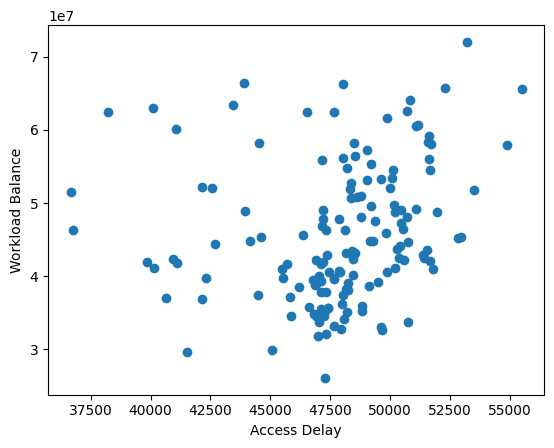

Average access delay:47798.18067547251
Average workload balance:45743791.6582861
Minimum access delay:36668.720369909264
Minimum workload balance:26093240.507964466


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27364\4269542047.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(population)),leave=False, desc='Next Generation'):


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 0, Species:54 Frontier: 0 distance: -inf Access Delay: 36668.720369909264 Workload Balance: 51559322.18541615 Servers: 20, Species: Gen 0, Species:59 Frontier: 0 distance: -inf Access Delay: 47258.69324023073 Workload Balance: 26093240.507964466 Servers: 20, Species: Gen 0, Species:44 Frontier: 0 distance: -0.0792815185588282 Access Delay: 41535.837086015934 Workload Balance: 29633976.316834185 Servers: 20, Species: Gen 0, Species:95 Frontier: 0 distance: -0.05614973471073534 Access Delay: 39853.83279524434 Workload Balance: 41946765.423842944 Servers: 20, Species: Gen 0, Species:107 Frontier: 0 distance: -0.04790475443081318 Access Delay: 40641.05795752861 Workload Balance: 36987571.496317066 Servers: 20, Species: Gen 1, Species:139 Frontier: 0 distance: -0.034970449280754365 Access Delay: 45290.36321912726 Workload Balance: 26868018.326488484 Servers: 20, Species: Gen 0, Species:132 Frontier: 0 distance: -0.028997323026053262 Access Delay: 40125.5937896018 Workload Bala

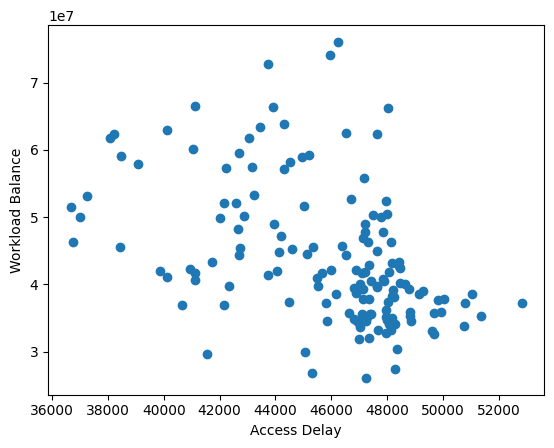

Average access delay:45770.65405183996
Average workload balance:44019732.273223035
Minimum access delay:36668.720369909264
Minimum workload balance:26093240.507964466


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 0, Species:59 Frontier: 0 distance: -inf Access Delay: 47258.69324023073 Workload Balance: 26093240.507964466 Servers: 20, Species: Gen 2, Species:21 Frontier: 0 distance: -inf Access Delay: 35656.22280777624 Workload Balance: 55562162.910216175 Servers: 20, Species: Gen 2, Species:119 Frontier: 0 distance: -0.05808597540158013 Access Delay: 35845.60550139705 Workload Balance: 48809771.425440796 Servers: 20, Species: Gen 1, Species:139 Frontier: 0 distance: -0.0288684220496502 Access Delay: 45290.36321912726 Workload Balance: 26868018.326488484 Servers: 20, Species: Gen 0, Species:73 Frontier: 0 distance: -0.020231026208369092 Access Delay: 36763.37460636943 Workload Balance: 46316241.21167942 Servers: 20, Species: Gen 1, Species:141 Frontier: 0 distance: -0.015170809089675868 Access Delay: 38440.786029814786 Workload Balance: 45607430.05029202 Servers: 20, Species: Gen 0, Species:44 Frontier: 0 distance: -0.014552098395987183 Access Delay: 41535.837086015934 Workload Bal

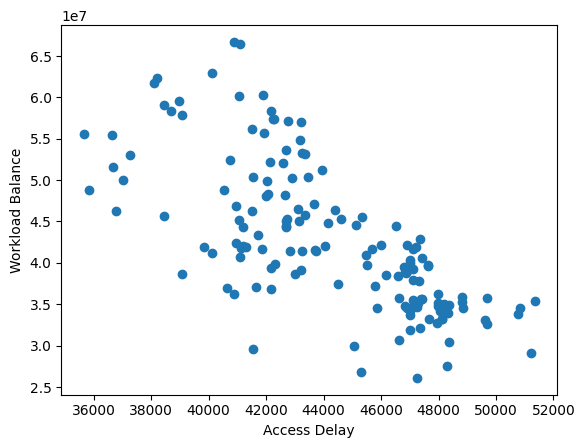

Average access delay:44160.22425177648
Average workload balance:42890213.99473828
Minimum access delay:35656.22280777624
Minimum workload balance:26093240.507964466


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 0, Species:59 Frontier: 0 distance: -inf Access Delay: 47258.69324023073 Workload Balance: 26093240.507964466 Servers: 20, Species: Gen 3, Species:6 Frontier: 0 distance: -inf Access Delay: 32226.68316932469 Workload Balance: 48247566.531812936 Servers: 20, Species: Gen 3, Species:60 Frontier: 0 distance: -0.1599988660857629 Access Delay: 35552.10383701947 Workload Balance: 46382110.98770681 Servers: 20, Species: Gen 1, Species:139 Frontier: 0 distance: -0.029370863451747865 Access Delay: 45290.36321912726 Workload Balance: 26868018.326488484 Servers: 20, Species: Gen 3, Species:37 Frontier: 0 distance: -0.012100963519717942 Access Delay: 37974.972503973455 Workload Balance: 40352730.42439935 Servers: 20, Species: Gen 3, Species:44 Frontier: 0 distance: -0.010641367279834904 Access Delay: 41988.96960738915 Workload Balance: 29566059.91689171 Servers: 20, Species: Gen 0, Species:73 Frontier: 0 distance: -0.009300524534714298 Access Delay: 36763.37460636943 Workload Balance

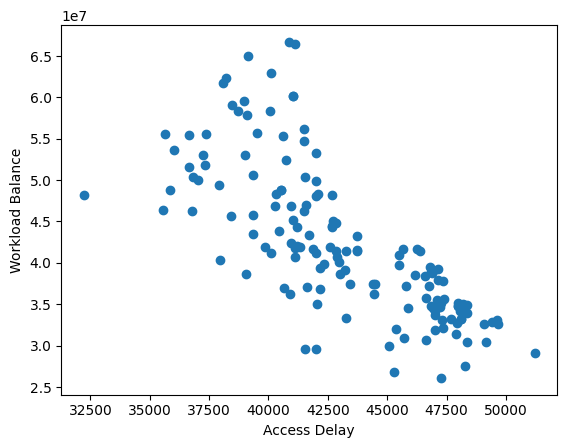

Average access delay:43114.529342439186
Average workload balance:42363000.825572774
Minimum access delay:32226.68316932469
Minimum workload balance:26093240.507964466


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 0, Species:59 Frontier: 0 distance: -inf Access Delay: 47258.69324023073 Workload Balance: 26093240.507964466 Servers: 20, Species: Gen 3, Species:6 Frontier: 0 distance: -inf Access Delay: 32226.68316932469 Workload Balance: 48247566.531812936 Servers: 20, Species: Gen 4, Species:36 Frontier: 0 distance: -0.15017720907198612 Access Delay: 34542.657799454 Workload Balance: 34311854.58898018 Servers: 20, Species: Gen 1, Species:139 Frontier: 0 distance: -0.037868967842189585 Access Delay: 45290.36321912726 Workload Balance: 26868018.326488484 Servers: 20, Species: Gen 0, Species:44 Frontier: 0 distance: -0.007550649990585441 Access Delay: 41535.837086015934 Workload Balance: 29633976.316834185 Servers: 20, Species: Gen 3, Species:44 Frontier: 0 distance: -0.004848353232628143 Access Delay: 41988.96960738915 Workload Balance: 29566059.91689171 Servers: 20, Species: Gen 4, Species:95 Frontier: 0 distance: -0.0035163124341846363 Access Delay: 40528.43074199284 Workload Balanc

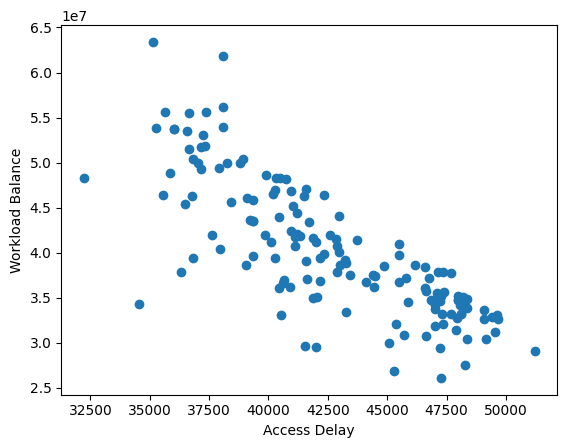

Average access delay:42674.62650699103
Average workload balance:40227488.179561205
Minimum access delay:32226.68316932469
Minimum workload balance:26093240.507964466


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 0, Species:59 Frontier: 0 distance: -inf Access Delay: 47258.69324023073 Workload Balance: 26093240.507964466 Servers: 20, Species: Gen 5, Species:27 Frontier: 0 distance: -inf Access Delay: 31332.762215263177 Workload Balance: 55907224.637748726 Servers: 20, Species: Gen 5, Species:42 Frontier: 0 distance: -0.07417189602341044 Access Delay: 33200.780384017744 Workload Balance: 41106526.77005171 Servers: 20, Species: Gen 5, Species:6 Frontier: 0 distance: -0.054615256588367564 Access Delay: 33934.63166830821 Workload Balance: 37913907.894918755 Servers: 20, Species: Gen 5, Species:92 Frontier: 0 distance: -0.04995706371828965 Access Delay: 32394.48495895455 Workload Balance: 46793218.56165925 Servers: 20, Species: Gen 3, Species:6 Frontier: 0 distance: -0.04985225253326402 Access Delay: 32226.68316932469 Workload Balance: 48247566.531812936 Servers: 20, Species: Gen 1, Species:139 Frontier: 0 distance: -0.0310816441243129 Access Delay: 45290.36321912726 Workload Balance: 

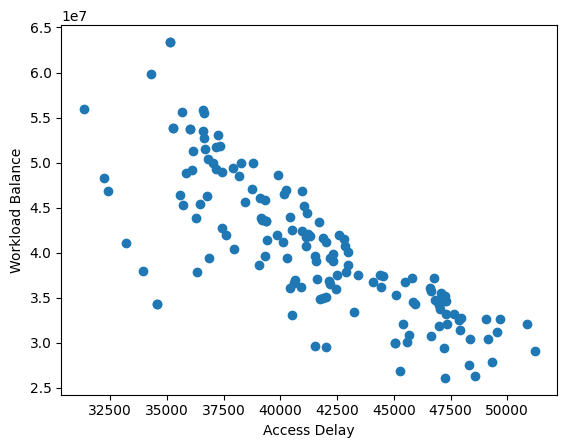

Average access delay:41457.830658558625
Average workload balance:40514136.86067185
Minimum access delay:31332.762215263177
Minimum workload balance:26093240.507964466


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 6, Species:4 Frontier: 0 distance: -inf Access Delay: 30938.41083835054 Workload Balance: 43168412.73980299 Servers: 20, Species: Gen 6, Species:16 Frontier: 0 distance: -inf Access Delay: 49926.28432189088 Workload Balance: 23765751.957309816 Servers: 20, Species: Gen 6, Species:41 Frontier: 0 distance: -0.04539552736050222 Access Delay: 46603.156369242526 Workload Balance: 25715555.98073334 Servers: 20, Species: Gen 1, Species:139 Frontier: 0 distance: -0.030355751521988456 Access Delay: 45290.36321912726 Workload Balance: 26868018.326488484 Servers: 20, Species: Gen 5, Species:42 Frontier: 0 distance: -0.026939065194023858 Access Delay: 33200.780384017744 Workload Balance: 41106526.77005171 Servers: 20, Species: Gen 6, Species:119 Frontier: 0 distance: -0.022180595013430757 Access Delay: 33907.60652801628 Workload Balance: 37758262.9367941 Servers: 20, Species: Gen 4, Species:36 Frontier: 0 distance: -0.01231065188289309 Access Delay: 34542.657799454 Workload Balance: 

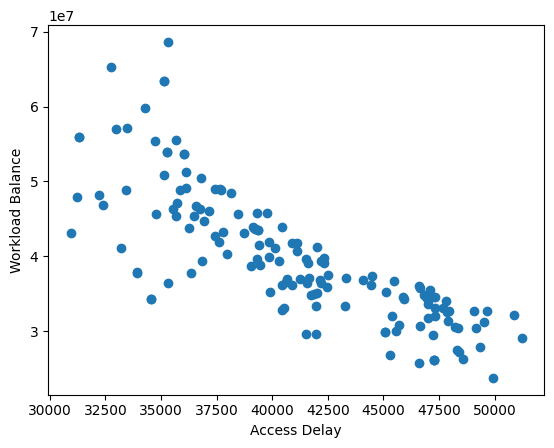

Average access delay:41054.57985059261
Average workload balance:39754169.08148403
Minimum access delay:30938.41083835054
Minimum workload balance:23765751.957309816


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 6, Species:4 Frontier: 0 distance: -inf Access Delay: 30938.41083835054 Workload Balance: 43168412.73980299 Servers: 20, Species: Gen 6, Species:16 Frontier: 0 distance: -inf Access Delay: 49926.28432189088 Workload Balance: 23765751.957309816 Servers: 20, Species: Gen 6, Species:41 Frontier: 0 distance: -0.04376597425998298 Access Delay: 46603.156369242526 Workload Balance: 25715555.98073334 Servers: 20, Species: Gen 1, Species:139 Frontier: 0 distance: -0.0335056253309606 Access Delay: 45290.36321912726 Workload Balance: 26868018.326488484 Servers: 20, Species: Gen 6, Species:119 Frontier: 0 distance: -0.02610218860058725 Access Delay: 33907.60652801628 Workload Balance: 37758262.9367941 Servers: 20, Species: Gen 7, Species:116 Frontier: 0 distance: -0.021155641048381815 Access Delay: 31715.21850280325 Workload Balance: 41208630.64920193 Servers: 20, Species: Gen 7, Species:47 Frontier: 0 distance: -0.0128924389681596 Access Delay: 30938.41083835054 Workload Balance: 43

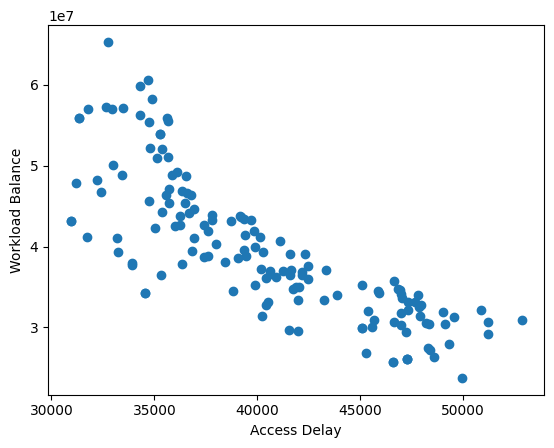

Average access delay:40326.19737895848
Average workload balance:39557808.25949331
Minimum access delay:30938.41083835054
Minimum workload balance:23765751.957309816


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 8, Species:81 Frontier: 0 distance: -inf Access Delay: 30003.261553101212 Workload Balance: 52351500.29424359 Servers: 20, Species: Gen 8, Species:130 Frontier: 0 distance: -inf Access Delay: 48699.92390116495 Workload Balance: 23721043.154652804 Servers: 20, Species: Gen 6, Species:41 Frontier: 0 distance: -0.040872029603508046 Access Delay: 46603.156369242526 Workload Balance: 25715555.98073334 Servers: 20, Species: Gen 1, Species:139 Frontier: 0 distance: -0.030109387782135427 Access Delay: 45290.36321912726 Workload Balance: 26868018.326488484 Servers: 20, Species: Gen 7, Species:116 Frontier: 0 distance: -0.020503525368800124 Access Delay: 31715.21850280325 Workload Balance: 41208630.64920193 Servers: 20, Species: Gen 0, Species:44 Frontier: 0 distance: -0.016956664462522874 Access Delay: 41535.837086015934 Workload Balance: 29633976.316834185 Servers: 20, Species: Gen 7, Species:47 Frontier: 0 distance: -0.011744114271136115 Access Delay: 30938.41083835054 Workload 

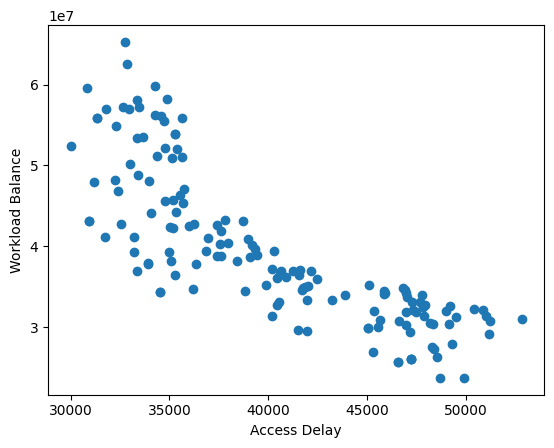

Average access delay:40107.21953935804
Average workload balance:39470366.98978032
Minimum access delay:30003.261553101212
Minimum workload balance:23721043.154652804


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 8, Species:81 Frontier: 0 distance: -inf Access Delay: 30003.261553101212 Workload Balance: 52351500.29424359 Servers: 20, Species: Gen 8, Species:130 Frontier: 0 distance: -inf Access Delay: 48699.92390116495 Workload Balance: 23721043.154652804 Servers: 20, Species: Gen 1, Species:139 Frontier: 0 distance: -0.029362044656686202 Access Delay: 45290.36321912726 Workload Balance: 26868018.326488484 Servers: 20, Species: Gen 6, Species:41 Frontier: 0 distance: -0.018575665555178283 Access Delay: 46603.156369242526 Workload Balance: 25715555.98073334 Servers: 20, Species: Gen 0, Species:44 Frontier: 0 distance: -0.017591834410790746 Access Delay: 41535.837086015934 Workload Balance: 29633976.316834185 Servers: 20, Species: Gen 5, Species:42 Frontier: 0 distance: -0.013236982906203083 Access Delay: 33200.780384017744 Workload Balance: 41106526.77005171 Servers: 20, Species: Gen 6, Species:4 Frontier: 0 distance: -0.011750929755230198 Access Delay: 30938.41083835054 Workload B

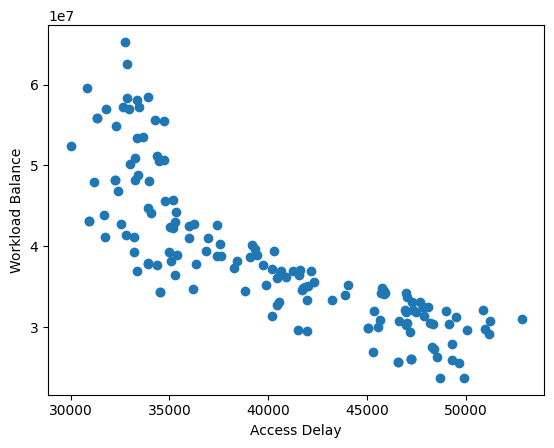

Average access delay:40077.17741548963
Average workload balance:38673717.21682932
Minimum access delay:30003.261553101212
Minimum workload balance:23721043.154652804


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 8, Species:81 Frontier: 0 distance: -inf Access Delay: 30003.261553101212 Workload Balance: 52351500.29424359 Servers: 20, Species: Gen 8, Species:130 Frontier: 0 distance: -inf Access Delay: 48699.92390116495 Workload Balance: 23721043.154652804 Servers: 20, Species: Gen 1, Species:139 Frontier: 0 distance: -0.01498418953522965 Access Delay: 45290.36321912726 Workload Balance: 26868018.326488484 Servers: 20, Species: Gen 7, Species:47 Frontier: 0 distance: -0.013026555713843875 Access Delay: 30938.41083835054 Workload Balance: 43168412.73980299 Servers: 20, Species: Gen 5, Species:54 Frontier: 0 distance: -0.01017759249418811 Access Delay: 34542.657799454 Workload Balance: 34311854.58898018 Servers: 20, Species: Gen 7, Species:116 Frontier: 0 distance: -0.008220364219709448 Access Delay: 31715.21850280325 Workload Balance: 41208630.64920193 Servers: 20, Species: Gen 0, Species:44 Frontier: 0 distance: -0.008164593320992784 Access Delay: 41535.837086015934 Workload Balanc

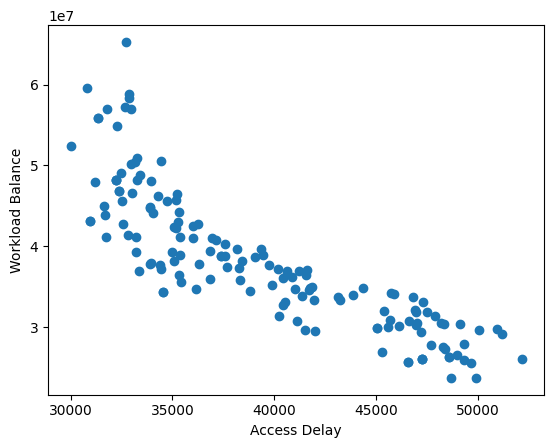

Average access delay:39367.80839938056
Average workload balance:38199390.383537985
Minimum access delay:30003.261553101212
Minimum workload balance:23721043.154652804


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 11, Species:69 Frontier: 0 distance: -inf Access Delay: 41890.84107699502 Workload Balance: 23718814.821133725 Servers: 20, Species: Gen 11, Species:90 Frontier: 0 distance: -inf Access Delay: 29903.126701459678 Workload Balance: 46886668.78817975 Servers: 20, Species: Gen 11, Species:118 Frontier: 0 distance: -0.02306567908575367 Access Delay: 32019.84826012562 Workload Balance: 39827685.530860186 Servers: 20, Species: Gen 11, Species:111 Frontier: 0 distance: -0.017214850952969984 Access Delay: 39479.192324447904 Workload Balance: 29347504.21738791 Servers: 20, Species: Gen 11, Species:147 Frontier: 0 distance: -0.013775772625968637 Access Delay: 35928.66279224372 Workload Balance: 31481655.940558136 Servers: 20, Species: Gen 4, Species:36 Frontier: 0 distance: -0.00973002605692119 Access Delay: 34542.657799454 Workload Balance: 34311854.58898018 Servers: 20, Species: Gen 6, Species:4 Frontier: 0 distance: -0.00963484594408975 Access Delay: 30938.41083835054 Workload Ba

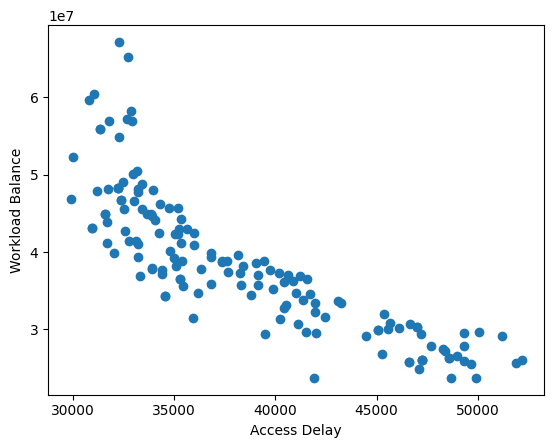

Average access delay:38455.770026031394
Average workload balance:38523838.41432173
Minimum access delay:29903.126701459678
Minimum workload balance:23718814.821133725


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 11, Species:69 Frontier: 0 distance: -inf Access Delay: 41890.84107699502 Workload Balance: 23718814.821133725 Servers: 20, Species: Gen 11, Species:90 Frontier: 0 distance: -inf Access Delay: 29903.126701459678 Workload Balance: 46886668.78817975 Servers: 20, Species: Gen 12, Species:74 Frontier: 0 distance: -0.02255223156689099 Access Delay: 37666.80620645957 Workload Balance: 31199691.649894822 Servers: 20, Species: Gen 11, Species:118 Frontier: 0 distance: -0.021708936545627285 Access Delay: 32019.84826012562 Workload Balance: 39827685.530860186 Servers: 20, Species: Gen 11, Species:111 Frontier: 0 distance: -0.01353221629518365 Access Delay: 39479.192324447904 Workload Balance: 29347504.21738791 Servers: 20, Species: Gen 12, Species:57 Frontier: 0 distance: -0.012241877409695356 Access Delay: 34385.27849566691 Workload Balance: 31591684.175889526 Servers: 20, Species: Gen 7, Species:47 Frontier: 0 distance: -0.00941283079083654 Access Delay: 30938.41083835054 Workloa

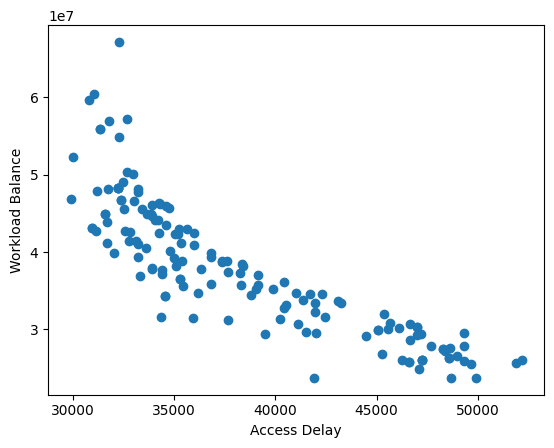

Average access delay:38391.12111609125
Average workload balance:37911652.41597357
Minimum access delay:29903.126701459678
Minimum workload balance:23718814.821133725


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 11, Species:69 Frontier: 0 distance: -inf Access Delay: 41890.84107699502 Workload Balance: 23718814.821133725 Servers: 20, Species: Gen 13, Species:11 Frontier: 0 distance: -inf Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20, Species: Gen 11, Species:90 Frontier: 0 distance: -0.04830274315030919 Access Delay: 29903.126701459678 Workload Balance: 46886668.78817975 Servers: 20, Species: Gen 11, Species:111 Frontier: 0 distance: -0.018207911923054806 Access Delay: 39479.192324447904 Workload Balance: 29347504.21738791 Servers: 20, Species: Gen 11, Species:118 Frontier: 0 distance: -0.016765409522570798 Access Delay: 32019.84826012562 Workload Balance: 39827685.530860186 Servers: 20, Species: Gen 13, Species:18 Frontier: 0 distance: -0.014385100601967942 Access Delay: 41435.023096015146 Workload Balance: 28751320.233080972 Servers: 20, Species: Gen 11, Species:147 Frontier: 0 distance: -0.01428767893962437 Access Delay: 35928.66279224372 Work

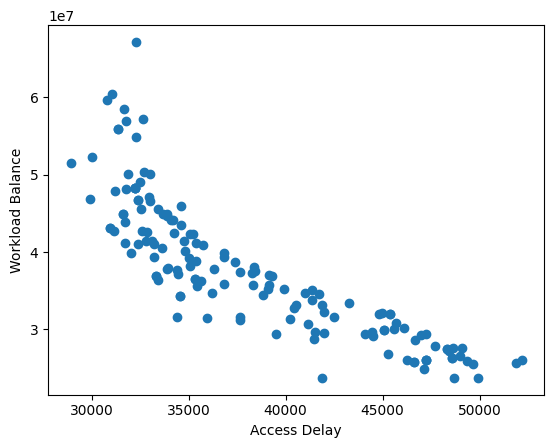

Average access delay:38233.60299039639
Average workload balance:37737889.57306775
Minimum access delay:28918.32374658219
Minimum workload balance:23718814.821133725


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 13, Species:11 Frontier: 0 distance: -inf Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20, Species: Gen 14, Species:99 Frontier: 0 distance: -inf Access Delay: 49134.21017477316 Workload Balance: 19983904.62292576 Servers: 20, Species: Gen 11, Species:69 Frontier: 0 distance: -0.0770965267399165 Access Delay: 41890.84107699502 Workload Balance: 23718814.821133725 Servers: 20, Species: Gen 11, Species:90 Frontier: 0 distance: -0.04627378552094912 Access Delay: 29903.126701459678 Workload Balance: 46886668.78817975 Servers: 20, Species: Gen 11, Species:118 Frontier: 0 distance: -0.012634180308334584 Access Delay: 32019.84826012562 Workload Balance: 39827685.530860186 Servers: 20, Species: Gen 11, Species:111 Frontier: 0 distance: -0.012398256040408423 Access Delay: 39479.192324447904 Workload Balance: 29347504.21738791 Servers: 20, Species: Gen 12, Species:74 Frontier: 0 distance: -0.012398146256577612 Access Delay: 37666.80620645957 Workload

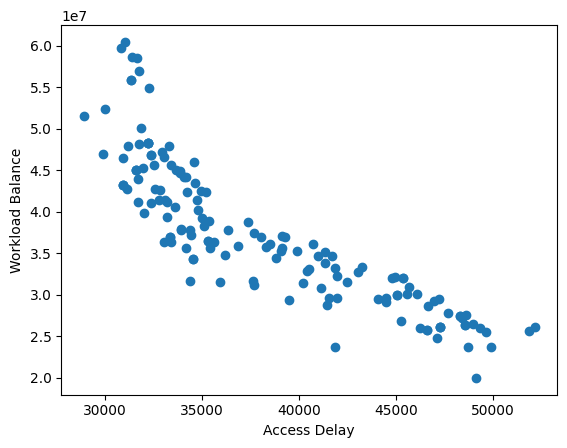

Average access delay:38199.7092386948
Average workload balance:37367171.57666225
Minimum access delay:28918.32374658219
Minimum workload balance:19983904.62292576


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 13, Species:11 Frontier: 0 distance: -inf Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20, Species: Gen 14, Species:99 Frontier: 0 distance: -inf Access Delay: 49134.21017477316 Workload Balance: 19983904.62292576 Servers: 20, Species: Gen 11, Species:69 Frontier: 0 distance: -0.07706083717681055 Access Delay: 41890.84107699502 Workload Balance: 23718814.821133725 Servers: 20, Species: Gen 11, Species:90 Frontier: 0 distance: -0.04538228091234668 Access Delay: 29903.126701459678 Workload Balance: 46886668.78817975 Servers: 20, Species: Gen 15, Species:92 Frontier: 0 distance: -0.028155274760818385 Access Delay: 40733.179609922605 Workload Balance: 24203796.324464984 Servers: 20, Species: Gen 15, Species:117 Frontier: 0 distance: -0.02637981050285352 Access Delay: 30330.350572795996 Workload Balance: 40885755.28427885 Servers: 20, Species: Gen 11, Species:111 Frontier: 0 distance: -0.014572081773605972 Access Delay: 39479.192324447904 Worklo

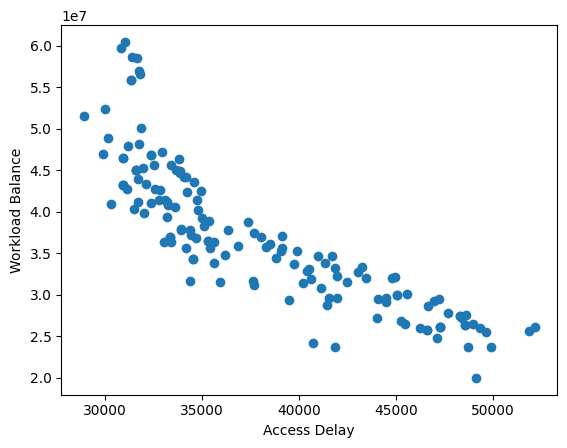

Average access delay:38046.824336685444
Average workload balance:37006664.626039766
Minimum access delay:28918.32374658219
Minimum workload balance:19983904.62292576


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 13, Species:11 Frontier: 0 distance: -inf Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20, Species: Gen 14, Species:99 Frontier: 0 distance: -inf Access Delay: 49134.21017477316 Workload Balance: 19983904.62292576 Servers: 20, Species: Gen 11, Species:69 Frontier: 0 distance: -0.0759863600573758 Access Delay: 41890.84107699502 Workload Balance: 23718814.821133725 Servers: 20, Species: Gen 16, Species:33 Frontier: 0 distance: -0.0527602063544622 Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20, Species: Gen 11, Species:90 Frontier: 0 distance: -0.05138511124291047 Access Delay: 29903.126701459678 Workload Balance: 46886668.78817975 Servers: 20, Species: Gen 15, Species:92 Frontier: 0 distance: -0.03286515627455197 Access Delay: 40733.179609922605 Workload Balance: 24203796.324464984 Servers: 20, Species: Gen 16, Species:110 Frontier: 0 distance: -0.02397982460048765 Access Delay: 30519.171137048226 Workload Bal

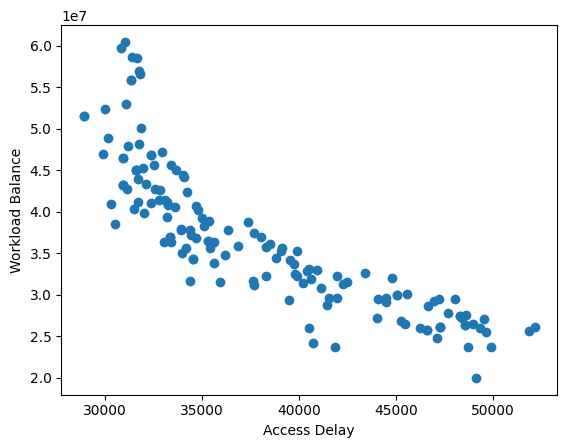

Average access delay:38016.69439600855
Average workload balance:36757203.95167462
Minimum access delay:28918.32374658219
Minimum workload balance:19983904.62292576


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 13, Species:11 Frontier: 0 distance: -inf Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20, Species: Gen 14, Species:99 Frontier: 0 distance: -inf Access Delay: 49134.21017477316 Workload Balance: 19983904.62292576 Servers: 20, Species: Gen 11, Species:69 Frontier: 0 distance: -0.07726411797368204 Access Delay: 41890.84107699502 Workload Balance: 23718814.821133725 Servers: 20, Species: Gen 16, Species:33 Frontier: 0 distance: -0.048284385919365916 Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20, Species: Gen 11, Species:90 Frontier: 0 distance: -0.04754967021302197 Access Delay: 29903.126701459678 Workload Balance: 46886668.78817975 Servers: 20, Species: Gen 16, Species:110 Frontier: 0 distance: -0.028757672692606852 Access Delay: 30519.171137048226 Workload Balance: 38453473.04986563 Servers: 20, Species: Gen 17, Species:70 Frontier: 0 distance: -0.022681457667119466 Access Delay: 39619.46763063537 Workload 

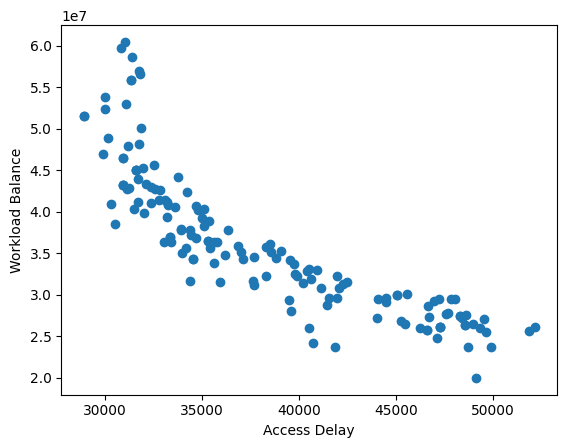

Average access delay:38200.94499038856
Average workload balance:36195812.554744504
Minimum access delay:28918.32374658219
Minimum workload balance:19983904.62292576


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 13, Species:11 Frontier: 0 distance: -inf Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20, Species: Gen 14, Species:99 Frontier: 0 distance: -inf Access Delay: 49134.21017477316 Workload Balance: 19983904.62292576 Servers: 20, Species: Gen 11, Species:90 Frontier: 0 distance: -0.05072727164393904 Access Delay: 29903.126701459678 Workload Balance: 46886668.78817975 Servers: 20, Species: Gen 16, Species:33 Frontier: 0 distance: -0.04402550599334848 Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20, Species: Gen 15, Species:92 Frontier: 0 distance: -0.02369986941253553 Access Delay: 40733.179609922605 Workload Balance: 24203796.324464984 Servers: 20, Species: Gen 11, Species:69 Frontier: 0 distance: -0.01985329345043869 Access Delay: 41890.84107699502 Workload Balance: 23718814.821133725 Servers: 20, Species: Gen 15, Species:117 Frontier: 0 distance: -0.016971922490989375 Access Delay: 30330.350572795996 Workload 

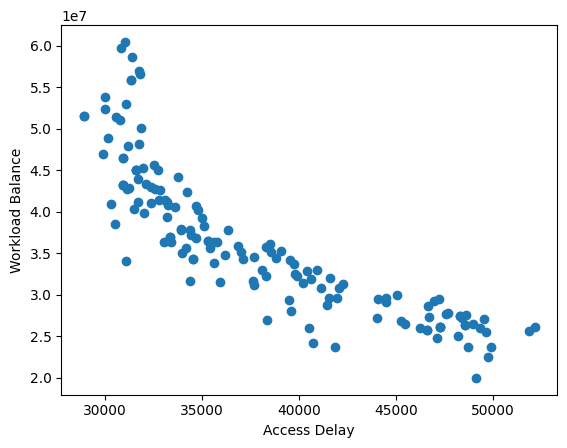

Average access delay:37928.93882657417
Average workload balance:36368681.90764005
Minimum access delay:28918.32374658219
Minimum workload balance:19983904.62292576


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 13, Species:11 Frontier: 0 distance: -inf Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20, Species: Gen 14, Species:99 Frontier: 0 distance: -inf Access Delay: 49134.21017477316 Workload Balance: 19983904.62292576 Servers: 20, Species: Gen 16, Species:33 Frontier: 0 distance: -0.03441507500788817 Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20, Species: Gen 11, Species:69 Frontier: 0 distance: -0.02080998054844282 Access Delay: 41890.84107699502 Workload Balance: 23718814.821133725 Servers: 20, Species: Gen 15, Species:92 Frontier: 0 distance: -0.01999224289524424 Access Delay: 40733.179609922605 Workload Balance: 24203796.324464984 Servers: 20, Species: Gen 11, Species:90 Frontier: 0 distance: -0.016447845174996683 Access Delay: 29903.126701459678 Workload Balance: 46886668.78817975 Servers: 20, Species: Gen 16, Species:110 Frontier: 0 distance: -0.01158688616038436 Access Delay: 30519.171137048226 Workload 

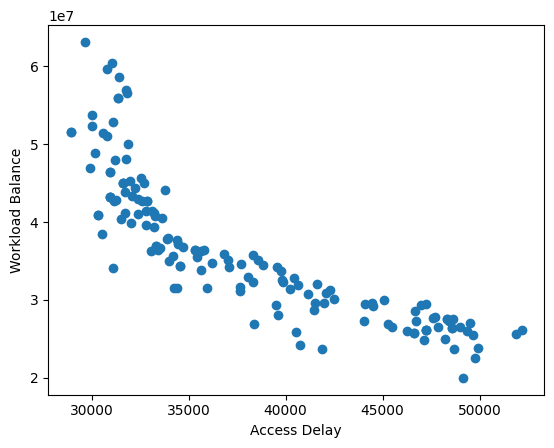

Average access delay:37844.15887804031
Average workload balance:36451850.593884185
Minimum access delay:28918.32374658219
Minimum workload balance:19983904.62292576


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

In [38]:
frontiers,population = evolution(df,pop_size=150)

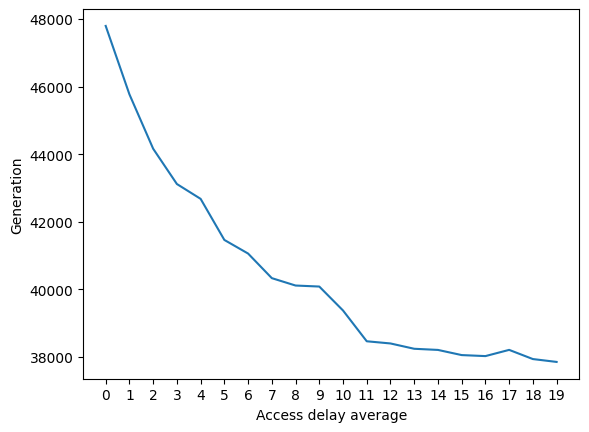

In [39]:
plt.xlabel("Access delay average")
plt.ylabel("Generation")
plt.xticks(range(0,20))
plt.plot(access_delay_averages)

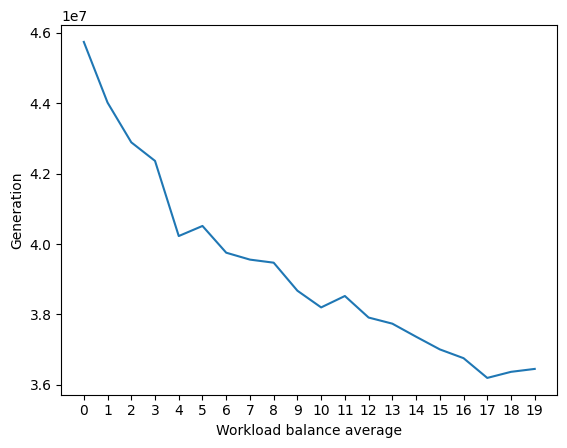

In [40]:
plt.xlabel("Workload balance average")
plt.ylabel("Generation")
plt.xticks(range(0,20))
plt.plot(workload_balance_averages)

In [1]:
import pickle

In [42]:
file = open("results.pickle","wb")
pickle.dump(population, file)

In [13]:
with open("results.pickle", 'rb') as f:
    population = pickle.load(f) 
f.close()
population

{'Gen 13, Species:11': Species: Gen 13, Species:11 Frontier: 0 distance: -inf Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20,
 'Gen 14, Species:99': Species: Gen 14, Species:99 Frontier: 0 distance: -inf Access Delay: 49134.21017477316 Workload Balance: 19983904.62292576 Servers: 20,
 'Gen 16, Species:33': Species: Gen 16, Species:33 Frontier: 0 distance: -inf Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20,
 'Gen 11, Species:69': Species: Gen 11, Species:69 Frontier: 0 distance: -0.5754789689941916 Access Delay: 41890.84107699502 Workload Balance: 23718814.821133725 Servers: 20,
 'Gen 11, Species:90': Species: Gen 11, Species:90 Frontier: 0 distance: -0.40778800271281807 Access Delay: 29903.126701459678 Workload Balance: 46886668.78817975 Servers: 20,
 'Gen 16, Species:110': Species: Gen 16, Species:110 Frontier: 0 distance: -0.25489512594485564 Access Delay: 30519.171137048226 Workload Balance: 38453473.04986563 Servers

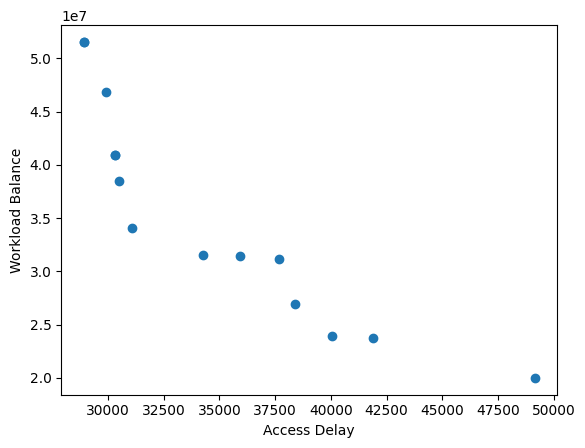

Average access delay:34809.11255163889
Average workload balance:35220290.56526888
Minimum access delay:28918.32374658219
Minimum workload balance:19983904.62292576


In [43]:
frontiers = nonDominatedSort(population)
front0 = {key:value for key,value in population.items() if value.id in frontiers[0]}
ads = []
wbs = []
for key,value in front0.items():
    ads.append(value.accessDelay)
    wbs.append(value.workloadBalance)
plt.xlabel("Access Delay")
plt.ylabel("Workload Balance")
plt.scatter(ads,wbs)
plt.show()
average_ad = sum(ads)/len(ads)
average_wb = sum(wbs)/len(wbs)
access_delay_averages.append(average_ad)
workload_balance_averages.append(average_wb)
access_delay_mins.append(min(ads))
workload_balance_mins.append(min(wbs))
print("Average access delay:" + str(average_ad))
print("Average workload balance:" + str(average_wb))
print("Minimum access delay:" + str(min(ads)))
print("Minimum workload balance:" + str(min(wbs)))

In [15]:
frontiers

defaultdict(list,
            {0: ['Gen 13, Species:11',
              'Gen 14, Species:99',
              'Gen 16, Species:33',
              'Gen 11, Species:69',
              'Gen 11, Species:90',
              'Gen 16, Species:110',
              'Gen 11, Species:147',
              'Gen 15, Species:117',
              'Gen 19, Species:124',
              'Gen 12, Species:74',
              'Gen 18, Species:86',
              'Gen 18, Species:124',
              'Gen 19, Species:76',
              'Gen 20, Species:70'],
             1: ['Gen 18, Species:11',
              'Gen 19, Species:93',
              'Gen 8, Species:130',
              'Gen 15, Species:134',
              'Gen 8, Species:81',
              'Gen 6, Species:4',
              'Gen 7, Species:47',
              'Gen 14, Species:129',
              'Gen 20, Species:146',
              'Gen 16, Species:36',
              'Gen 14, Species:48',
              'Gen 11, Species:118',
              'Gen 15, Species:128

In [17]:
solutions=[]
for value in front0:
    solutions.append(value)

solutionA = front0[solutions[0]]
solutionB = front0[solutions[-1]]

In [18]:
type(population)

dict

In [19]:
solutionA

Species: Gen 13, Species:11 Frontier: 0 distance: -inf Access Delay: 28918.32374658219 Workload Balance: 51554865.14924295 Servers: 20

In [24]:
print("Access delay:" + str(solutionA.accessDelay))
print("Workload balance:" + str(solutionA.workloadBalance))

Access delay:28918.32374658219
Workload balance:51554865.14924295


In [27]:
import folium
m = folium.Map(location=[31.224361, 121.469170], zoom_start=9)

for index, row in df.iterrows():
    folium.CircleMarker(
        location=row['location'],
        radius=row['workload'] / 500000,  # size by workload
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

for index, row in df.iloc[solutionA.servers].iterrows():
    folium.CircleMarker(
        location=row['location'],
        radius=10,
        color='black',
        fill=True,
        fill_color='black'
    ).add_to(m)

m

In [22]:
solutionA.accessDelay

28918.32374658219

In [ ]:
print("Access delay:" + str(solutionB.accessDelay))
print("Workload balance:" + str(solutionB.workloadBalance))

In [29]:
solutionB

Species: Gen 20, Species:70 Frontier: 0 distance: -0.2764051092568479 Access Delay: 40040.59300982856 Workload Balance: 23950911.66606568 Servers: 20

In [28]:
import folium
m = folium.Map(location=[31.224361, 121.469170], zoom_start=9)

for index, row in df.iterrows():
    folium.CircleMarker(
        location=row['location'],
        radius=row['workload'] / 500000,  # size by workload
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

for index, row in df.iloc[solutionB.servers].iterrows():
    folium.CircleMarker(
        location=row['location'],
        radius=10,
        color='black',
        fill=True,
        fill_color='black'
    ).add_to(m)

m